In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import tensorflow as tf

In [5]:
tf.__version__

'2.9.2'

In [6]:
!nvidia-smi

Sun Nov 20 18:28:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [56]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50
CHANNELS = 3

In [10]:
dataset = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/NEW_LEARNING/Deep_Learning/Potato_disease_classification/PlantVillage',
                                            shuffle = True,
                                            image_size = (IMAGE_SIZE, IMAGE_SIZE),
                                            batch_size = BATCH_SIZE)

Found 651 files belonging to 3 classes.


In [11]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [12]:
len(dataset)

21

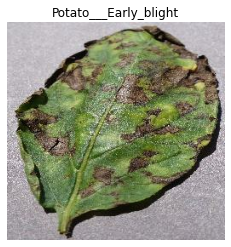

In [26]:
for image_batch, label_batch in dataset.take(1):
  plt.imshow(image_batch[0].numpy().astype("uint8"))
  plt.title(class_names[label_batch[0]])
  plt.axis("off")

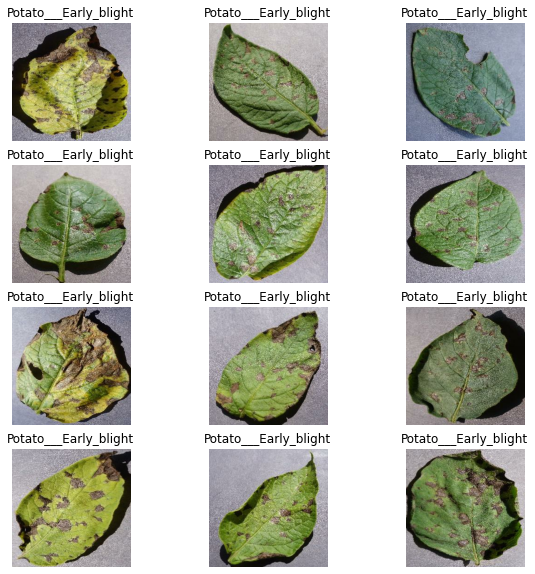

In [30]:
for image_batch, label_batch in dataset.take(1):
  plt.figure(figsize=(10, 10))
  for i in range(12):
    ax = plt.subplot(4,3,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [32]:
len(dataset)

21

In [33]:
train_size = 0.8
len(dataset)*train_size

16.8

In [34]:
train_ds = dataset.take(16)
len(train_ds)

16

In [36]:
test_ds = dataset.skip(16)
len(test_ds)

5

In [39]:
val_size = 0.1
(len(dataset))*val_size

2.1

In [40]:
val_ds = test_ds.take(2)
len(val_ds)

2

In [41]:
test_ds = test_ds.skip(2)
len(test_ds)

3

In [47]:
def get_dataset_partitions_tf(ds, train_split=0.8, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size=10000):
  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(ds_size*train_split)
  val_size = int(ds_size * val_split)

  train_ds = ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [48]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [49]:
len(train_ds)

16

In [50]:
len(val_ds)

2

In [51]:
len(test_ds)

3

In [52]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [53]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [54]:
data_agumentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [59]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_agumentation,
    layers.Conv2D(32, (3,3), input_shape=input_shape, activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [60]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [61]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [62]:
history = model.fit(
    train_ds, 
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
16/16 [==============================] - 55s 241ms/step - loss: 0.2017 - accuracy: 0.9348 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/50
16/16 [==============================] - 1s 90ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/50
16/16 [==============================] - 1s 88ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/50
16/16 [==============================] - 1s 88ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/50
16/16 [==============================] - 1s 88ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/50
16/16 [==============================] - 1s 88ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/50
16/16 [==============================] - 1s 93ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val

In [63]:
scores = model.evaluate(test_ds)

3/3 [==============================] - 2s 37ms/step - loss: 0.0000e+00 - accuracy: 1.0000


In [64]:
scores

[0.0, 1.0]

In [65]:
history

In [66]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 16}

In [68]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [69]:
history.history['accuracy']

[0.9348269104957581,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [70]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

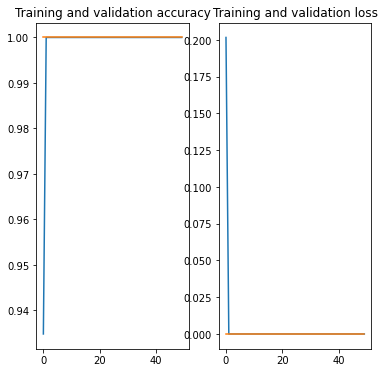

In [78]:
plt.figure(figsize=(6,6))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training loss')
plt.plot(range(EPOCHS), val_loss, label="Validation loss")
plt.title("Training and validation loss")
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 33ms/step
Predicted label: Potato___Early_blight


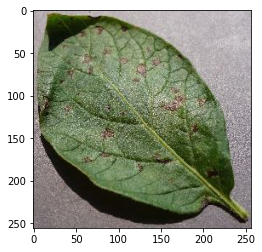

In [87]:
import numpy as np
for image_batch, label_batch in test_ds.take(1):
  first_image = image_batch[0].numpy().astype("uint8")
  first_label = class_names[label_batch[0]]

  print("first image to predict")
  plt.imshow(first_image)
  print("actual label:", first_label)

  batch_predict = model.predict(image_batch)
  print("Predicted label:", class_names[np.argmax(batch_predict[0])])

In [97]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)

  predicted_classes = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_classes, confidence

1/1 [==============================] - 0s 17ms/step


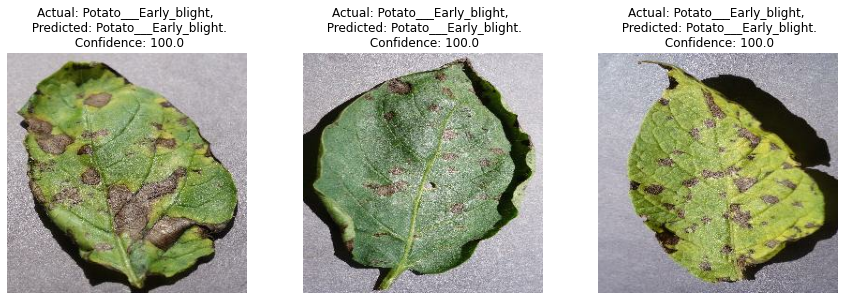

In [98]:
for images, labels in test_ds.take(1):
  plt.figure(figsize=(15, 15))
  for i in range(len(test_ds)):
    plt.subplot(3,3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i])
    actual_class = class_names[np.argmax(labels[i])]

    plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}")
    plt.axis("off")

In [111]:
import os
model_version = max([int(i) for i in os.listdir('../models')])+1
print(model_version)
model.save(f"../models/{model_version}")

4


In [101]:
# model_version = 1
# model.save(f"../models/{model_version}")